# Homework Set 5


In [163]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
import yfinance as yf
import datetime 
import pandas_datareader as pdr
from scipy.stats import chi
seed=2

**Run this cell to display math properly!**
$\renewcommand{bs}{\mathbf}$

**Unless explicitly forbidden, you can use any standard python function from `numpy`/`scipy`/`pandas`/`matplotlib` or the lectures to solve homework problems. DO NOT use other packages like `Quantlib`/`Quandl`/`portfoliolab`/`etc`.**

## Problem 1 (50 points)

A basket (put or call) option is an option on a basket of securities, commodities, or currencies (it is similar to an option on index).

Who uses basket options?
* Multinational corporations that want to hedge against a number of FX risks.
* Investors who wish to have a broad exposure to (or hedge) particular portfolios, industry sectors, or countries.

Index options are an alternative to basket options, but if the index does not match the desired portfolio there will be significant tracking error risk that can cost more than the additional cost of the basket option. Another alternative is a collection of individual stock options, but this may be more expensive due to transaction costs and because the implied volatility of each option includes a large component of specific stock risk which may be diversified in a basket.

The discounted payoff function is given by:

$$
V_{\text{basket}} =
e^{-rT} \left( \sum_i^m x_i S_i(T) - K \right)^+
$$

where $S_i(t)$ is the asset value at time $t$ of asset $i$, $m$ is the number of assets in the basket, $x_i$, is the weight of asset $i$ in the basket (which does not change over time), $K$ is the strike price, $r$ is the risk-free rate, and $T$ is the time to maturity.

You have a client that wants to protect their portfolio of tech stocks for the next year by purchasing an at-the-money basket put option on the five stocks in the portfolio (IBM, NFLX, MSFT, FB, and AAPL), where the stocks are equally-weighted. Using Monte-Carlo, compute the price (along with the estimated error) of the basket option for your client. (You may assume that the risk-free rate is 2% and you can use the last year of daily prices to compute the correlation matrix). **NB**: Obviously you need to provide your code.

Buy a put basket option to sell the portfolio at an strike price when their value is low.

In [25]:
tickers = ['IBM', 'NFLX', 'MSFT', 'FB', 'AAPL']
df = pdr.DataReader(tickers, data_source='yahoo', start='2021-03-11', end='2022-03-11')['Adj Close']

In [236]:
df_lr = np.log(1 + df.pct_change())
std_5 = df_lr.std()
cov_5 = df_lr.cov()
# to obtain the same correlation
L_5 = np.linalg.cholesky(cov_5)

In [237]:
def mc_basket(N,M):
    '''
    Inputs:
        N: the number of iterations to run
        M: the number of time-steps
    '''
    np.random.seed(seed) 
    dt = 1 / M
    rdm = np.random.standard_normal((5, M + 1, N))
    C0=[]
    S_ = np.zeros([5,N])

    for i in range(5):
        sum_sig = sum([L_5[i,k]*np.sqrt(dt)*rdm[k] for k in range(5)])
        # Simulating N paths with M time steps
        S =  df.iloc[-1][i]* np.exp(np.cumsum((0.02 - 0.5 * std_5[i] ** 2) * dt + sum_sig, axis=0))
        # form the price matrix form calculation
        S_[i]=S[-1]
        
    Strk = np.mean(df.iloc[-1])
    C = np.maximum(np.mean(S_,axis=0)-Strk,0)
    C0 = np.exp(-0.02 * 1) * sum(C)/N
    var = np.sqrt(np.var(C)/N)
    return C0,var

In [238]:
print(f'the estimate price for the at-the-money option is', mc_basket(1000,1000)[0])
print(f'the error for the approximation is', mc_basket(1000,1000)[1])

the estimate price for the at-the-money option is 4.420598849813196
the error for the approximation is 0.09683657703165441


## Problem 2 (50 points)

The square root diffusion process was first proposed by [Cox, Ingersoll, and Ross (1985)](https://www.sciencedirect.com/science/article/abs/pii/0304405X94900167) to model interest rates and has been quite popular for other uses. For example, it was applied by [Heston (2015)](https://academic.oup.com/rfs/article-abstract/6/2/327/1574747?redirectedFrom=fulltext&login=false) to model stochastic volatility in option pricing. The model is given by the following stochastic differential equation:

$$
d x_t = \kappa ( \theta - x_t ) dt + \sigma \sqrt{x_t} dZ_t
$$

where $x_t$ is the process level at time $t$, $\kappa$ is the mean-reversion factor, $\theta$ is the long term mean of the process, $\sigma$ is the constant volatility, and $Z$ is standard Brownian motion.

While it is well known that the values of $x_t$ are distributed chi-squared, it is often discretized and approximated using a normal distribution. This is what is known as the Euler discretization scheme (this is the general technique used in the course so far). The CIR process can be discretized (using the Euler scheme) as:  

$$
x_t = x_{t-1} + \kappa ( \theta - x_{t-1} ) \delta t + \sigma \sqrt{x_{t-1} \delta t} z_t
$$

In this case, the use of a normal distribution creates a slight problem. While the square-root diffusion requires that the values of $x_t$ be strictly positive, the use of the normal distribution produces both positive **and** negative values. In the simulation, this can be "fixed" two ways:
1. *Truncation method*: where we use $x^+ = \max(x,0)$:

$$
x_t = x_{t-1} + \kappa ( \theta - x_{t-1}^+ ) \delta t + \sigma \sqrt{x_{t-1}^+ \delta t} z_t
$$

2. *Reflection method*: where we use a positive value "as is" and "reflect" a negative value by changing the sign (alternatively, one could take an absolute value):

$$
x_t = \begin{cases}
x_{t-1} + \kappa ( \theta - x_{t-1} ) \delta t + \sigma \sqrt{x_{t-1} \delta t} z_t & \text{  if $>0$}\\
x_{t-1} + \kappa ( \theta - x_{t-1} ) \delta t - \sigma \sqrt{x_{t-1} \delta t} z_t & \text{  if $<0$}
\end{cases}
$$

There is a third method, the **exact** discretization scheme, based on the noncentral chi-squared distribution $\chi_d^2$, which can be written:

$$
x_t = \frac{\sigma^2 (1-e^{-\kappa \delta t})}{4 \kappa} 
\chi_d^2 \bigg( \frac{4 \kappa e^{-\kappa \delta t}}{\sigma^2(1-e^ {-\kappa \delta t})}x_{t-1} \bigg)
$$

where the noncentral parameter is in the parenthesis for the $\chi^2$ distribution, and the degrees of freedom are given by:

$$
d = \frac{4 \theta \kappa}{\sigma^2}
$$

(a) Develop the `python` code for each of these three methods and test the pricing using the parameters $T=1$, $x_0 = 0.1$, $\kappa = 0.5$, $\theta = 0.1$, and $\sigma = 0.8$ (reporting the errors with each). You want to make sure that you are comparing apples-to-apples: same seed (=2), same parameters, same number of time periods, and same number of paths.
(b) Plot the time series of the truncated value against the reflecting value. Do you have any observations?
(c) Compute the cost of running each of the methods and compare. Which is better and why?

In [196]:
#a
def generate_z(n_paths, dt, t_maturity, seed=2):
    np.random.seed(seed)
    n_time_steps = int(t_maturity/dt + 1e-6)
    z1 = np.random.normal(size=n_paths*n_time_steps) # get the right number of rv's
    z1 = (z1 - z1.mean())/z1.std() # normalize so they are N(0,1)
    z_matrix = z1.reshape(n_paths,n_time_steps) # reshape to proper dimension
    
    return z_matrix

def diffusion_proc(x0, kp, th, sig, mtd, dt, z,seed=2):
    x_s = []
    x = np.ones(len(z)) * x0
    x_s.append(x)   
    if mtd==1:
        for i in range(z.shape[1]):
            xp = np.maximum(x, 0)
            x = x + kp * (th - xp) * dt + sig * np.sqrt(xp * dt)*z[:,i] 
            x_s.append(x)
            
    if mtd==2:
        for i in range(z.shape[1]):
            kk = x + kp * (th - x) * dt + sig * np.sqrt(x * dt) *z[:,i]
            bb = x + kp * (th - x) * dt - sig * np.sqrt(x * dt) *z[:,i]
            x = np.array([kk[i] if kk[i] > 0 else bb[i] for i in range(len(kk))])
            x_s.append(x)
            
    if mtd==3:
        for i in range(z.shape[1]):
            ins = (4 * kp * np.exp(-kp*dt)) / (sig**2 * (1 - np.exp(-kp*dt)))*x
            df = (4 * th * kp) / sig**2
            chi_ = chi.rvs(df=df, loc=ins, random_state=seed)
            x = (sig**2 * (1-np.exp(-kp*dt))) / (4 * kp) * chi_
            x_s.append(x)    
        
    return np.array(x_s).T

def outcome(xx,n):
    x = xx[:,-1]
    return np.mean(x), np.sqrt(np.var(x)/n), xx[-1]

In [195]:
p=generate_z(3,0.1,1,2)
diffusion_proc(0.1,0.5,0.1,0.8,1,0.1,p)

array([[ 0.1       ,  0.09277418,  0.11540972, -0.04864457, -0.04364457,
        -0.03864457, -0.03364457, -0.02864457, -0.02364457, -0.01864457,
        -0.01364457],
       [ 0.1       ,  0.17429193,  0.46214699,  0.51145638,  0.34103389,
         0.46425056,  0.39792389,  0.4353954 ,  0.68318926,  0.56227641,
         0.60703359],
       [ 0.1       ,  0.05393122,  0.06702408,  0.10916856,  0.05084009,
         0.05282458,  0.0609814 ,  0.04276617, -0.00154036,  0.00345964,
         0.0110654 ]])

In [201]:
#b

T, x0, kappa, theta, sigma, n_paths = 1, 0.1, 0.5, 0.1, 0.8, 1000
n_time_steps = 100
dt = T / n_time_steps
z = generate_z(n_paths, dt, T, seed=2)

# Truncation method
ts = time.time()
xx1 = diffusion_proc(x0, kappa, theta, sigma, 1, dt, z ,seed=2)
x1, error1, sample1 = outcome(xx1, n_paths)
t1 = time.time() - ts

# Reflection method
ts = time.time()
xx2 = diffusion_proc(x0, kappa, theta, sigma, 2, dt, z ,seed=2)
x2, error2, sample2 = outcome(xx2, n_paths)
t2 = time.time() - ts

# Exact method
ts = time.time()
xx3 = diffusion_proc(x0, kappa, theta, sigma, 3, dt, z ,seed=2)
x3, error3, sample3 = outcome(xx3, n_paths)
t3 = time.time() - ts


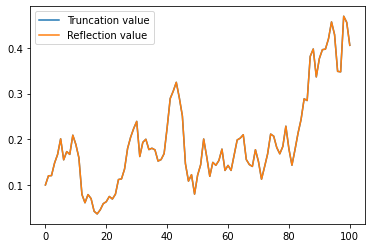

In [202]:
plt.figure()
plt.plot(sample1, label='Truncation value')
plt.plot(sample2, label='Reflection value')
plt.legend()
plt.show()

They look the same because their value never reach negative in this sample 

In [205]:
#c
ddf= pd.DataFrame([[n_paths, x1, error1, t1], [n_paths, x2, error2, t2], [n_paths, x3, error3, t3]],\
                  columns=['Path_number', 'Simulated_Value', 'error', 'Time cost'], \
                  index=['Truncation', 'Reflection', 'Exact Discretization'])


In [206]:
ddf

,Path_number,Simulated_Value,error,Time cost
Truncation,1000,0.106991,0.006388,0.002859
Reflection,1000,0.155558,0.006390,0.057444
Exact Discretization,1000,0.098987,0.001858,0.029968
